In [1]:

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import matplotlib.patches as patches
import os

from torchvision.io import read_image
import torch
import torchvision
from torchvision import transforms
from torchvision import ops
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence



In [3]:
from dataset import BoarDataset
dataset = BoarDataset(img_path="data/Wild Boar.v1i.yolov7pytorch/train/images",
                      annotation_path="data/Wild Boar.v1i.yolov7pytorch/train/labels",
                      yolo_format=True)
dataset[1]

{'image': tensor([[[0.0902, 0.0863, 0.0863,  ..., 0.1098, 0.1216, 0.1216],
          [0.0980, 0.0902, 0.0863,  ..., 0.1176, 0.1294, 0.1255],
          [0.1098, 0.1020, 0.0941,  ..., 0.1294, 0.1412, 0.1333],
          ...,
          [0.7451, 0.7608, 0.7804,  ..., 0.5333, 0.5686, 0.3569],
          [0.7608, 0.7843, 0.7765,  ..., 0.5020, 0.5725, 0.3373],
          [0.7804, 0.8000, 0.7804,  ..., 0.4745, 0.5882, 0.3451]],
 
         [[0.0471, 0.0431, 0.0431,  ..., 0.0549, 0.0588, 0.0588],
          [0.0549, 0.0471, 0.0431,  ..., 0.0627, 0.0667, 0.0627],
          [0.0667, 0.0588, 0.0510,  ..., 0.0745, 0.0784, 0.0706],
          ...,
          [0.5529, 0.5804, 0.6039,  ..., 0.3647, 0.3882, 0.1765],
          [0.5804, 0.6078, 0.6118,  ..., 0.3333, 0.3922, 0.1569],
          [0.6000, 0.6235, 0.6196,  ..., 0.3059, 0.4078, 0.1647]],
 
         [[0.0627, 0.0588, 0.0588,  ..., 0.0549, 0.0627, 0.0627],
          [0.0706, 0.0627, 0.0588,  ..., 0.0627, 0.0706, 0.0667],
          [0.0824, 0.0745, 0.06

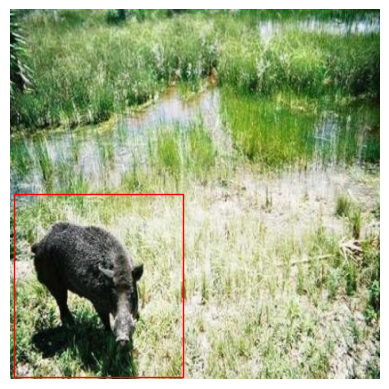

In [21]:
from utils import show_image_with_boxes
image = dataset[1500]['image']
boxes = dataset[1500]['target']['boxes']
show_image_with_boxes(image, boxes.tolist())

#### Double checking if the dataset outputs correct boxes

In [5]:
dataset[100][0].shape

torch.Size([3, 300, 300])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F
import torch
from dataset import BoarDataset  # Make sure to import your dataset class

def show_image_with_boxes(img_tensor, boxes_tensor, ax=None):
    """
    Display an image with bounding boxes.
    
    Parameters:
    - img_tensor: Tensor of the image data with pixel values in [0, 1].
    - boxes_tensor: Tensor of bounding boxes, each defined as [x_min, y_min, x_max, y_max].
    - ax: Matplotlib Axes object for plotting. If None, creates a new figure.
    """
    # Create a matplotlib figure and axis if none are provided
    if ax is None:
        fig, ax = plt.subplots(1)
    
    # Convert the image tensor to a PIL image (assuming it's in CxHxW format)
    img = F.to_pil_image(img_tensor)

    # Display the image
    ax.imshow(img)

    # Add the bounding boxes
    for box in boxes_tensor:
        x_min, y_min, x_max, y_max = box
        # Create a Rectangle patch
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
    
    # Remove axis details
    ax.axis('off')

# Example usage:
# Assuming dataset is an instance of BoarDataset and has at least one image loaded.
# dataset = BoarDataset()
img, boxes, _ = dataset[40]  # Get the first image and its boxes
# pred_boxes = [[126.8480, 170.6379, 251.9388, 263.5575],
#         [105.5562, 162.1955, 272.3223, 277.7397],
#         [ 75.3411, 161.7917, 278.6782, 276.3635]]
# pred_boxes = [[  4.9647,   1.1418, 297.5484, 298.1326],
#         [  5.7333,   0.0000, 298.8187, 298.2177],
#         [ 69.3078,  61.0620, 131.8305, 211.8529],]
show_image_with_boxes(img, boxes)
plt.show()


### Training the model

In [1]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, ssd300_vgg16, ssdlite320_mobilenet_v3_large
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import torch
import torchvision

#### Preparing the dataset

In [2]:
from dataset import BoarDataset


# Use the custom collate function in your DataLoader
def collate_fn(batch):
    images = [item['image'] for item in batch]
    targets = [item['target'] for item in batch]
    return images, targets

train_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to Tensor and scale to [0,1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalization for pre-trained models
                         std=[0.229, 0.224, 0.225])
])
train_dataset = BoarDataset(transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [3]:
train_dataset[0]

{'image': tensor([[[-1.3130, -1.2274, -1.1760,  ..., -1.0219, -0.7822, -1.2103],
          [-1.3130, -1.2274, -1.1760,  ..., -1.0733, -0.7993, -1.3987],
          [-1.3130, -1.2274, -1.1760,  ..., -1.0904, -0.9534, -1.6042],
          ...,
          [ 0.1597,  0.1426,  0.1939,  ..., -0.9877, -0.9705, -0.9534],
          [ 0.0398, -0.0287,  0.0056,  ..., -0.9705, -0.9534, -0.9363],
          [-0.0629, -0.1143, -0.1486,  ..., -0.9705, -0.9534, -0.9363]],
 
         [[-1.2479, -1.1604, -1.0728,  ..., -0.9503, -0.7227, -1.1604],
          [-1.2479, -1.1779, -1.0728,  ..., -1.0028, -0.7402, -1.3529],
          [-1.2654, -1.1779, -1.0728,  ..., -1.0203, -0.8978, -1.5630],
          ...,
          [ 0.2577,  0.2752,  0.2927,  ..., -0.4776, -0.4601, -0.4426],
          [ 0.0826,  0.0651,  0.0476,  ..., -0.4601, -0.4426, -0.4251],
          [-0.0224, -0.0749, -0.1099,  ..., -0.4601, -0.4426, -0.4251]],
 
         [[-1.2293, -1.1421, -0.9853,  ..., -0.9853, -0.7587, -1.2293],
          [-1.2293,

In [4]:
for image, target in train_loader:
    print(target)
    break

[{'boxes': tensor([[ 83., 123., 202., 269.],
        [104.,  86., 204., 146.]]), 'labels': tensor([1, 1])}]


In [5]:
model = fasterrcnn_mobilenet_v3_large_fpn(num_classes=2, weights_backbone=torchvision.models.MobileNet_V3_Large_Weights,trainable_backbone_layers=0)

/opt/homebrew/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights_backbone=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights_backbone=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
device = torch.device("mps")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for images, targets in train_loader:
        print("starting training")
        images = [image.to(device) for image in images]
        targets = [{k : v.to(device) for k, v in target.items()} for target in targets]
        print("trying to do a forward pass")
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        print(losses, loss_dict)
        # asdofjasd
        # optimizer.zero_grad()
        # losses.backward()
        # optimizer.step()
    break
    print(f'Epoch: {epoch}, Loss: {losses.item()}')


starting training
trying to do a forward pass


In [10]:
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, ssd300_vgg16, ssdlite320_mobilenet_v3_large
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.optim as optim
import torch
import torchvision
#### Preparing the dataset
from dataset import BoarDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as F
import torch
from dataset import BoarDataset  # Make sure to import your dataset class
from utils import show_image_with_boxes

# Use the custom collate function in your DataLoader
def collate_fn(batch):
    images = [item['image'] for item in batch]
    targets = [item['target'] for item in batch]
    return images, targets

train_transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to Tensor and scale to [0,1]
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalization for pre-trained models
    #                      std=[0.229, 0.224, 0.225])
])
train_dataset = BoarDataset(img_path='data/train/images',annotation_path='data/train/labels',transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

# for image, target in train_loader:
#     print(image, target)
#     break
# model = fasterrcnn_mobilenet_v3_large_fpn(num_classes=2, weights_backbone=torchvision.models.MobileNet_V3_Large_Weights.IMAGENET1K_V1,trainable_backbone_layers=0)
model = ssd300_vgg16(num_classes=2, weights_backbone=torchvision.models.VGG16_Weights.IMAGENET1K_V1,trainable_backbone_layers=0)



In [2]:
# model.load_state_dict(torch.load("models/fasterrcnn_mobilenetv3_epoch5.pth"))

In [14]:
train_dataset[0]['image'].shape

torch.Size([3, 300, 300])

In [16]:
model.eval()
model(train_dataset[0]['image'])

ValueError: images is expected to be a list of 3d tensors of shape [C, H, W], got torch.Size([300, 300])

In [6]:
import os
from datetime import datetime
from utils import get_current_time

CURRENT_TIME = get_current_time()
MODEL_PATH = f"models/{CURRENT_TIME}"
MODEL_NAME = "fasterrcnn_mobilenet_v3_large_fpn"
os.mkdir(MODEL_PATH)
torch.save(model.state_dict(), f"{MODEL_PATH}/{MODEL_NAME}.pth")

In [9]:
os.mkdir(f"models2")

In [12]:
from datetime import datetime
datetime.now().strftime("%d/%m/%Y %H:%M:%S")

'10/05/2024 13:42:16'

In [24]:
train_dataset[0]['image']

tensor([[[0.1843, 0.2039, 0.2157,  ..., 0.2510, 0.3059, 0.2078],
         [0.1843, 0.2039, 0.2157,  ..., 0.2392, 0.3020, 0.1647],
         [0.1843, 0.2039, 0.2157,  ..., 0.2353, 0.2667, 0.1176],
         ...,
         [0.5216, 0.5176, 0.5294,  ..., 0.2588, 0.2627, 0.2667],
         [0.4941, 0.4784, 0.4863,  ..., 0.2627, 0.2667, 0.2706],
         [0.4706, 0.4588, 0.4510,  ..., 0.2627, 0.2667, 0.2706]],

        [[0.1765, 0.1961, 0.2157,  ..., 0.2431, 0.2941, 0.1961],
         [0.1765, 0.1922, 0.2157,  ..., 0.2314, 0.2902, 0.1529],
         [0.1725, 0.1922, 0.2157,  ..., 0.2275, 0.2549, 0.1059],
         ...,
         [0.5137, 0.5176, 0.5216,  ..., 0.3490, 0.3529, 0.3569],
         [0.4745, 0.4706, 0.4667,  ..., 0.3529, 0.3569, 0.3608],
         [0.4510, 0.4392, 0.4314,  ..., 0.3529, 0.3569, 0.3608]],

        [[0.1294, 0.1490, 0.1843,  ..., 0.1843, 0.2353, 0.1294],
         [0.1294, 0.1569, 0.1843,  ..., 0.1725, 0.2314, 0.0863],
         [0.1373, 0.1569, 0.1843,  ..., 0.1686, 0.1961, 0.

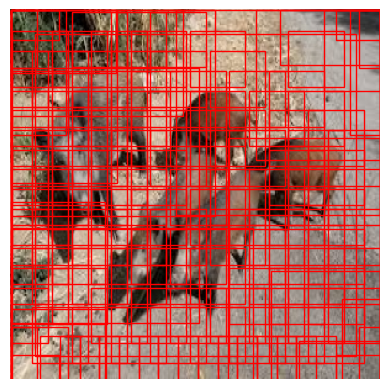

In [33]:
model.eval()
images = [train_dataset[8]['image']]
boxes = model(images)
THRESHOLD = 0.4
boxes_score_zip = zip(boxes[0]['boxes'], boxes[0]['scores'])
boxes = [box.tolist() for box, score in boxes_score_zip if score > THRESHOLD]
show_image_with_boxes(images[0], boxes, save_path="results/exp1.jpg")
plt.show()

In [8]:
boxes = model(images)


In [9]:
boxes

[{'boxes': tensor([[ 14.7196, 144.5712, 116.2714, 208.0035],
          [ 59.2746, 153.8417, 106.7009, 207.3875],
          [ 21.3897, 152.7083,  84.1963, 200.5850],
          [111.1081, 161.7926, 161.9837, 201.8542],
          [ 12.0442, 124.1426, 130.3952, 248.0462],
          [178.7449, 154.2797, 225.3616, 198.2181],
          [185.3283, 167.0679, 220.6650, 189.1806],
          [191.1965, 158.5114, 212.2287, 194.8504],
          [183.2969, 159.2425, 217.7948, 183.3708],
          [120.7335, 167.2508, 158.3432, 190.3579],
          [130.6822, 163.5217, 152.4768, 198.3073],
          [120.4308, 164.9117, 141.2711, 198.0953],
          [  0.0000, 135.6624, 179.1246, 218.8606],
          [200.9339, 189.3481, 268.0369, 282.4095],
          [124.2176, 178.2433, 160.2066, 200.4362],
          [120.3034, 161.4436, 147.8609, 185.8649],
          [ 79.1581, 153.1342, 103.0814, 200.9036],
          [182.0479, 157.7139, 201.4378, 188.5645],
          [107.6041, 165.8107, 126.9286, 198.3982],
   

In [11]:
boxes[0]['scores']

tensor([0.9546, 0.7817, 0.6850, 0.6752, 0.6517, 0.6310, 0.5663, 0.5573, 0.5382,
        0.4578, 0.4265, 0.3249, 0.2926, 0.2429, 0.2260, 0.2022, 0.1872, 0.1848,
        0.1712, 0.1696, 0.1640, 0.1561, 0.1446, 0.1350, 0.1307, 0.1225, 0.1154,
        0.1108, 0.1104, 0.1091, 0.1026, 0.0998, 0.0980, 0.0976, 0.0952, 0.0934,
        0.0914, 0.0913, 0.0842, 0.0842, 0.0837, 0.0835, 0.0809, 0.0799, 0.0766,
        0.0764, 0.0762, 0.0725, 0.0702, 0.0679, 0.0655, 0.0637, 0.0637, 0.0637,
        0.0635, 0.0633, 0.0625, 0.0620, 0.0607, 0.0571, 0.0558, 0.0514],
       grad_fn=<IndexBackward0>)

In [11]:
import imageio
import os

def create_gif(image_folder, gif_path, duration=0.5):
    """
    Create a GIF from a series of JPEG images in a folder.

    Parameters:
    - image_folder: Path to the folder containing JPEG images.
    - gif_path: Path to save the GIF file.
    - duration: Duration of each frame in seconds (default is 0.5 seconds).
    """
    images = []
    # Iterate through all the JPEG files in the folder
    for filename in sorted(os.listdir(image_folder)):
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):
            file_path = os.path.join(image_folder, filename)
            images.append(imageio.imread(file_path))

    # Save the images as a GIF
    imageio.mimsave(gif_path, images, duration=duration)

# Example usage:
image_folder = "results"
gif_path = "output.gif"
create_gif(image_folder, gif_path)


/var/folders/1b/scr2b5v14f92bf6sh5g4bgrc0000gn/T/ipykernel_24039/2066955655.py:18: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))
